<a href="https://colab.research.google.com/github/HealLink/ML-Model/blob/ryan's-experiment/notebook_bert_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import-import
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.utils
import re
import csv
import json

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf.get_logger().setLevel('ERROR')

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [5]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive # type: ignore
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "../data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Step 1: Data cleaning

In [6]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

--2024-12-13 13:38:50--  https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh
Resolving drive.google.com (drive.google.com)... 142.251.10.102, 142.251.10.101, 142.251.10.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download [following]
--2024-12-13 13:38:50--  https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.68.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31469558 (30M) [application/octet-stream]
Saving to: ‘../data/combined_data.csv’

../data/combined_da 100%[===================>]  30.01M 

In [7]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [8]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Step 1a: Basic cleaning

In [10]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    362
status         0
dtype: int64
Number of duplicate rows: 1969


In [11]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [12]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    0
status       0
dtype: int64
Number of duplicate rows: 0


### Step 1b: Deep cleaning

In [13]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text) # remove number
    text = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)", " ", text) # remove links
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [15]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [16]:
# Data distribution analysis of each label
df.status.value_counts()

status
Normal                  16035
Depression              15087
Suicidal                10640
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [17]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [18]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [19]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

word_count_range
1-100       32894
101-200      9570
201-300      4223
301-400      1949
401-500      1002
501-600       542
601-700       311
701-800       191
801-900       116
901-1000       69
+1000         201
Name: count, dtype: int64

In [20]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

/tmp/ipykernel_51447/3797327473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)


status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
word_count_range,,,,,,,
1-100,1793,956,6878,15761,353,1429,5724
101-200,995,806,4064,271,260,643,2531
201-300,430,369,1987,3,154,126,1154
301-400,190,167,968,0,61,38,525
401-500,93,95,468,0,30,30,286
501-600,44,48,270,0,13,13,154
601-700,25,22,158,0,11,2,93
701-800,17,11,98,0,4,6,55
801-900,16,15,48,0,4,3,30


In [24]:
df_correct_size = df[(df['word_count'] >= 10) & (df['word_count'] <= 192)].reset_index(drop=True)
df_correct_size.status.value_counts()

status
Depression              10424
Normal                   8266
Suicidal                 7839
Anxiety                  2449
Stress                   2035
Bipolar                  1709
Personality disorder      583
Name: count, dtype: int64

In [25]:
df_export_candidate = df_correct_size
df_export_candidate

,statement,status,word_count,word_count_range
0,"trouble sleeping, confused mind, restless hear...",Anxiety,10,1-100
1,"all wrong, back off dear, forward doubt. stay ...",Anxiety,14,1-100
2,i've shifted my focus to something else but i'...,Anxiety,11,1-100
3,"i'm restless and restless, it's been a month n...",Anxiety,14,1-100
4,"every break, you must be nervous, like somethi...",Anxiety,14,1-100
...,...,...,...,...
33300,anxiety cause faintness when standing up ? as ...,Anxiety,23,1-100
33301,anxiety heart symptom does anyone else have th...,Anxiety,61,1-100
33302,travel anxiety hi all! long time anxiety suffe...,Anxiety,158,101-200
33303,fomo from things i’m not involved in does anyo...,Anxiety,171,101-200


In [26]:
df_export_candidate.status.value_counts()

status
Depression              10424
Normal                   8266
Suicidal                 7839
Anxiety                  2449
Stress                   2035
Bipolar                  1709
Personality disorder      583
Name: count, dtype: int64

In [27]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data_final.csv', index=False)

In [28]:
del df
del df_correct_size
del df_export_candidate

# Step 2: Prepare model

In [29]:
CLASS_NUM = 7

SEQ_LENGTH = 256
TRAINING_RATIO = 0.8
BATCH_SIZE = 4
SEED = 45

MODEL_DROPOUT_RATE = 0.2
MODEL_L2_REGULARIZER = 0.02

EPOCHS = 5
INIT_LR = 2e-5
WARM_UP_RATIO = 0.1

## Step 2a: Choosing model

In [30]:
bert_model_name = 'bert-en-uncased-l-12-h-768-a-12'
tfhub_handle_encoder = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-12-h-768-a-12/2"
tfhub_handle_preprocess = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-12-h-768-a-12/2
Preprocess model auto-selected: https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3


## Step 2b: BERT Preprocess

In [31]:
def make_bert_preprocess_model(tfhub_handle_preprocess, sentence_features, seq_length=SEQ_LENGTH):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [32]:
test_preprocess_model = make_bert_preprocess_model(tfhub_handle_preprocess, ['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

del test_preprocess_model
del test_text

I0000 00:00:1734072162.027932   51447 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1734072162.032439   51447 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 256)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 256)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 256)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


## Step 2c: Defining classifier model

In [33]:
@tf.keras.utils.register_keras_serializable('capstone')
class Classifier(tf.keras.Model):
  def __init__(self, tfhub_handle_encoder, num_classes, dropout_rate, l2):
    super(Classifier, self).__init__(name="prediction")
    self.num_classes = num_classes
    self.dropout_rate = dropout_rate
    self.l2 = l2
    self.tfhub_handle_encoder = tfhub_handle_encoder
    self.encoder = hub.KerasLayer(self.tfhub_handle_encoder, trainable=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dense = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(l2))

  def call(self, preprocessed_text):
    encoder_outputs = self.encoder(preprocessed_text)
    pooled_output = encoder_outputs["pooled_output"]
    x = self.dropout(pooled_output)
    x = self.dense(x)
    return x
  
  def get_config(self):
    config = super(Classifier, self).get_config()
    config.update({
        "num_classes": self.num_classes,
        "dropout_rate": self.dropout_rate,
        "l2": self.l2,
        "tfhub_handle_encoder": self.tfhub_handle_encoder
    })
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [34]:
test_classifier_model = Classifier(tfhub_handle_encoder, 2, 0.1, 0.01)
bert_raw_result = test_classifier_model(text_preprocessed)

print(f'Shape of the output: {bert_raw_result.shape}')
print(bert_raw_result)
print(tf.sigmoid(bert_raw_result))

del test_classifier_model
del bert_raw_result

Shape of the output: (1, 2)
tf.Tensor([[ 0.53623486 -0.43295708]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.63093615 0.39342043]], shape=(1, 2), dtype=float32)


# Step 3: Preprocess dataset

## Step 3a: Load dataset

In [35]:
sentences = []
labels = []

with open(data_dir+'/cleaned_data_final.csv', 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

print(f"There're {len(sentences)} sentences")

There're 33305 sentences


## Step 3b: Split dataset

In [36]:
train_sentences, val_test_sentences, train_labels, val_test_labels = sklearn.model_selection.train_test_split(
    sentences, labels,
    train_size=TRAINING_RATIO,
    stratify=labels,
    random_state=SEED
)

val_sentences, test_sentences, val_labels, test_labels = sklearn.model_selection.train_test_split(
    val_test_sentences, val_test_labels,
    train_size=0.5,
    stratify=val_test_labels,
    random_state=SEED
)

## Step 3c: Encode label

In [37]:
classes = np.unique(train_labels)
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_to_index = {label: index for index, label in enumerate(classes)}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
val_labels_encoded = np.array([class_to_index[label] for label in val_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

print("Classes:", classes)
print("Class Weights:", class_weight_dict)
print("Class mapping:", class_to_index)

Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Class Weights: {0: 1.942973820462335, 1: 2.7844079841153726, 2: 0.45644390385966116, 3: 0.5755762459225335, 4: 8.150504741511165, 5: 2.338013338013338, 6: 0.6069663074925393}
Class mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


## Step 3d: create tf.data.Dataset

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))

train_dataset = train_dataset.map(lambda x, y : (x, tf.one_hot(y, depth=CLASS_NUM)))
val_dataset = val_dataset.map(lambda x, y : (x, tf.one_hot(y, depth=CLASS_NUM)))
test_dataset = test_dataset.map(lambda x, y : (x, tf.one_hot(y, depth=CLASS_NUM)))

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.")
print(f"There are {val_dataset.cardinality()} sentence-label pairs for validation.")
print(f"There are {test_dataset.cardinality()} sentence-label pairs for test.")

There are 26644 sentence-label pairs for training.
There are 3330 sentence-label pairs for validation.
There are 3331 sentence-label pairs for test.


## Step 3e: optimize dataset

In [39]:
# Optimize the datasets for training
train_dataset_batched = (train_dataset
                       .shuffle(train_dataset.cardinality(), seed=SEED)
                       .cache()
                       .prefetch(buffer_size=tf.data.AUTOTUNE)
                       .batch(BATCH_SIZE)
                       )

val_dataset_batched = (val_dataset
                      .cache()
                      .prefetch(buffer_size=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      )

test_dataset_batched = (test_dataset
                      .cache()
                      .prefetch(buffer_size=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      )

## Step 3c: preprocess statement using bert_preprocess

In [40]:
for statement, label in train_dataset.take(1):
    print(statement)
    print(label)

tf.Tensor(b'i have been hiding in a cave within myself, it is been a few years since i have no friends, i walked away from everything and everyone, i think this was a mechanism of defense. i became a coward, i thought nothing scared me, but one thing scares me a shit: the pain, and nowadays i am so weak that even before i feel pain i think about suicide to relieve me. i think nietzsche was right when he said, "the idea of suicide is a big one consolation, helps to apply many bad nights". ** under the cave**', shape=(), dtype=string)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)


2024-12-13 13:43:43.276506: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
bert_preprocess_model = make_bert_preprocess_model(tfhub_handle_preprocess, ['sentence'], SEQ_LENGTH)

train_dataset_final = train_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))
val_dataset_final = val_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))
test_dataset_final = test_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))

In [42]:
# delete previous variable
del sentences
del train_sentences
del val_test_sentences
del val_sentences
del test_sentences

del labels
del train_labels
del val_test_labels
del val_labels
del test_labels

del train_dataset
del val_dataset
del test_dataset

del train_dataset_batched
del val_dataset_batched
del test_dataset_batched

# Step 4: How To Train Your ~~Dragon~~ ML Model

## Step 4a: preparing classifier_model

In [43]:
classifier_model = Classifier(tfhub_handle_encoder, CLASS_NUM, MODEL_DROPOUT_RATE, MODEL_L2_REGULARIZER)
bert_raw_result = classifier_model(text_preprocessed)
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.3032881  0.05161938 0.28558305 0.12364814 0.02909251 0.11722283
  0.08954597]], shape=(1, 7), dtype=float32)


In [44]:
@tf.keras.utils.register_keras_serializable('capstone')
class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, dtype=None, name="matthews_correlation_coefficient"):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name)
        self.num_classes = num_classes
        self.c = self.add_weight(name="total_correct_predicted", initializer="zeros", dtype=tf.float32)
        self.s = self.add_weight(name="total_samples", initializer="zeros", dtype=tf.float32)
        self.t = self.add_weight(name="num_true", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.p = self.add_weight(name="num_pred", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot labels to integer labels
        if len(y_true.shape) > 1:
            y_true = tf.argmax(y_true, axis=-1)
        if len(y_pred.shape) > 1:
            y_pred = tf.argmax(y_pred, axis=-1)
        
        # Total number of samples
        new_s = tf.cast(tf.size(y_true), tf.float32)
        # Total number of correctly predicted labels
        new_c = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        
        # Update state
        self.s.assign(tf.add(self.s, new_s))
        self.c.assign(tf.add(self.c, new_c))

        for k in range(self.num_classes):
            k = tf.cast(k, y_true.dtype)
            tk = tf.reduce_sum(tf.cast(tf.equal(y_true, k), tf.float32))
            pk = tf.reduce_sum(tf.cast(tf.equal(y_pred, k), tf.float32))
            self.t[k].assign(tf.add(self.t[k], tk))
            self.p[k].assign(tf.add(self.p[k], pk))
    
    def result(self):
        num = self.c * self.s - tf.reduce_sum(self.t * self.p)
        denom_t = tf.reduce_sum(self.t * self.t)
        denom_p = tf.reduce_sum(self.p * self.p)
        denom = tf.sqrt((self.s**2 - denom_t) * (self.s**2 - denom_p))
        
        mcc = tf.divide(num, denom + 1e-6)
        return mcc
    
    def reset_state(self):
        self.c.assign(0)
        self.s.assign(0)
        self.t.assign(tf.zeros_like(self.t))
        self.p.assign(tf.zeros_like(self.p))
    
    def get_config(self):
        config = super(MatthewsCorrelationCoefficient, self).get_config()
        config.update({
            "num_classes": self.num_classes
            })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [45]:
loss = tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.CategoricalAccuracy(), MatthewsCorrelationCoefficient(num_classes=CLASS_NUM)]

steps_per_epoch = tf.data.experimental.cardinality(train_dataset_final).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(WARM_UP_RATIO * num_train_steps)

optimizer = optimization.create_optimizer(
        init_lr=INIT_LR,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw'
    )

In [46]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [47]:
classifier_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  5383      
                                                                 
Total params: 109487624 (417.66 MB)
Trainable params: 109487623 (417.66 MB)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________


In [48]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	classifier_model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = classifier_model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-12-13 13:43:59.240698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-13 13:44:01.345106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (4, 7)


## Step 4b: Preparing callbacks

In [49]:
base_checkpoint = data_dir+'/checkpoint'

In [51]:
# Run thif if you don't determine to load existing checkpoint
checkpoint_path = base_checkpoint
counter = 1

while os.path.exists(checkpoint_path):
    checkpoint_path = f"{base_checkpoint}_{counter}"
    counter += 1

os.makedirs(checkpoint_path)

checkpoint_model_filepath = checkpoint_path+"/checkpoint_{epoch:02d}.tf"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

In [56]:
# Run this if you want to load certain checkpoint
checkpoint_path = f"{data_dir}/checkpoint_9" # customize this line

checkpoint_model_filepath = checkpoint_path+"/checkpoint_{epoch:02d}.tf"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

In [57]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_model_filepath)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "loss": [], "categorical_accuracy": [], "matthews_correlation_coefficient": [],
                        "val_loss": [], "val_categorical_accuracy": [], "val_matthews_correlation_coefficient": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            with open(self.epoch_file, 'w') as f:
                f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch)
        self.history["loss"].append(logs.get("loss"))
        self.history["categorical_accuracy"].append(logs.get("categorical_accuracy"))
        self.history["matthews_correlation_coefficient"].append(logs.get("matthews_correlation_coefficient"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_categorical_accuracy"].append(logs.get("val_categorical_accuracy"))
        self.history["val_matthews_correlation_coefficient"].append(logs.get("val_matthews_correlation_coefficient"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [60]:
# Load checkpoint
checkpoint_folder_name = "checkpoint_9"
try:
    with open(f"{data_dir}/{checkpoint_folder_name}/current_epoch.txt", 'r') as f:
        start_epoch = int(f.read())
    print(f"Latest epoch: {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# checkpoint_num = "{start_epoch:02d}" # use this to resume the latest epoch
checkpoint_num = 2 # use this to load from specific epoch

# Load saved model
if start_epoch > 0:
    classifier_model = tf.keras.models.load_model(f"{data_dir}/{checkpoint_folder_name}/checkpoint_{checkpoint_num:02d}.tf", custom_objects={
                                                                                                "Classifier": Classifier, 
                                                                                                "AdamWeightDecay": optimization.AdamWeightDecay,
                                                                                                "WarmUp": optimization.WarmUp,
                                                                                                "MatthewsCorrelationCoefficient": MatthewsCorrelationCoefficient,
                                                                                            })
    print(f"Loaded model from {checkpoint_folder_name} epoch {checkpoint_num}")

Latest epoch: 3
Loaded model from checkpoint_9 epoch 2


## Step 4c: TRAIN!!!

In [55]:
history = classifier_model.fit(
    train_dataset_final,
    epochs=EPOCHS,
    initial_epoch=start_epoch,
    validation_data=val_dataset_final,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback,
        early_stopping_callback
    ]
    )

Epoch 1/5
4441/6661 [===================>..........] - ETA: 13:26 - loss: 0.4352 - categorical_accuracy: 0.6291 - matthews_correlation_coefficient: 0.5202

KeyboardInterrupt: 

## Step 4d: EVALUATE!!!

In [61]:
loss, accuracy, mcc = classifier_model.evaluate(test_dataset_final)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')

833/833 [==============================] - 81s 96ms/step - loss: 0.0840 - categorical_accuracy: 0.8013 - matthews_correlation_coefficient: 0.7454
Loss: 0.08396897464990616
Accuracy: 0.8012608885765076
MCC: 0.7453916072845459


833/833 [==============================] - 78s 93ms/step


2024-12-13 14:20:32.864782: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


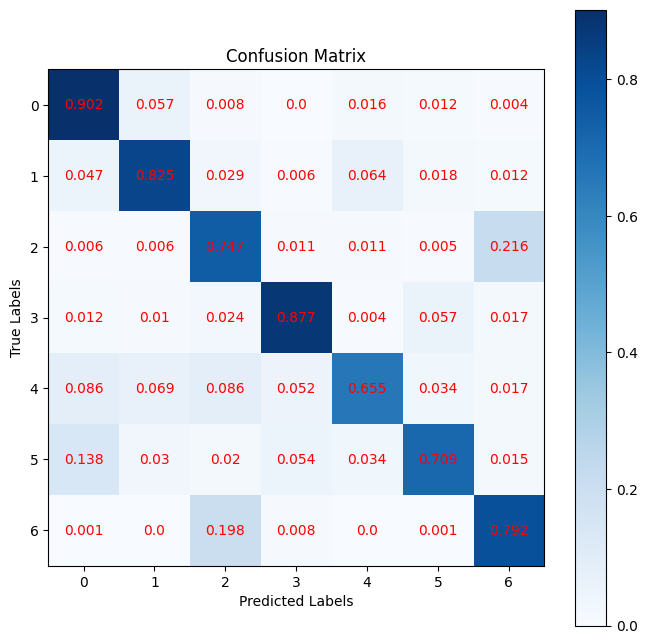

In [62]:
# Get predictions on the test set
y_pred_probs = classifier_model.predict(test_dataset_final)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test dataset
y_true = np.argmax(np.concatenate([y for x, y in test_dataset_final], axis=0), axis=-1)

# Optional: Normalize the confusion matrix
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

cm_normalized_short= np.around(cm_normalized.astype('float') / cm_normalized.sum(axis=1)[:, np.newaxis], decimals=3)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.colorbar()

# Add labels to each cell
for i in range(cm_normalized_short.shape[0]):
    for j in range(cm_normalized_short.shape[1]):
        plt.text(j, i, cm_normalized_short[i, j], ha='center', va='center', color='red')

plt.show()

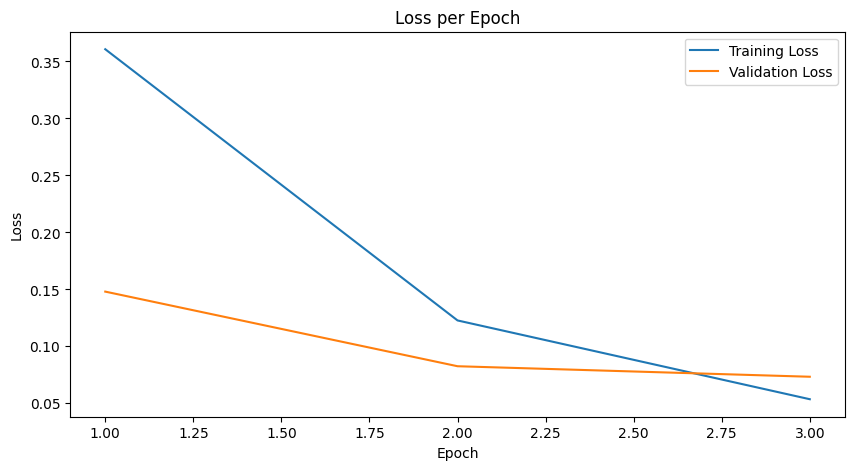

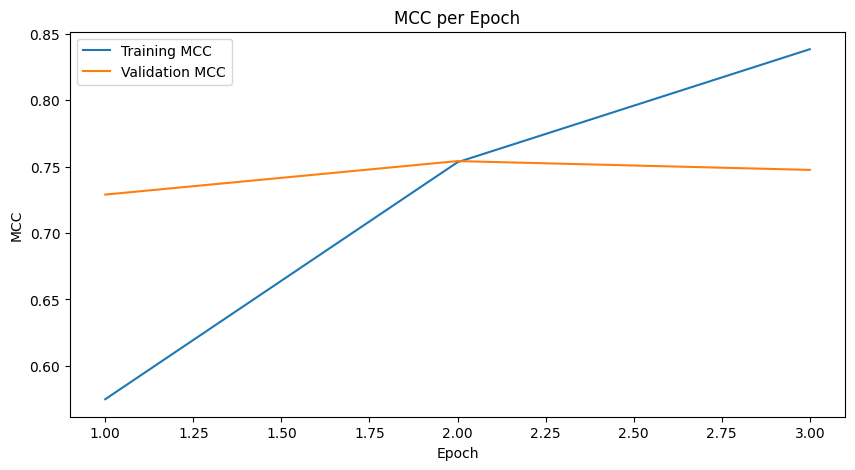

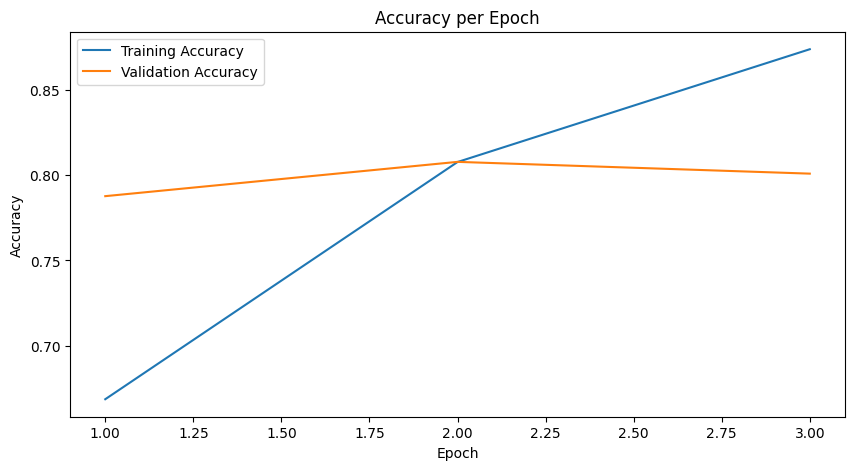

In [63]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["matthews_correlation_coefficient"], label="Training MCC")
    plt.plot(history["epoch"], history["val_matthews_correlation_coefficient"], label="Validation MCC")
    plt.title("MCC per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MCC")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["categorical_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_categorical_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 5: Save & Test the model

In [65]:
main_save_path = '../models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{"final_mental_model"}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)
preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)
model_for_export.save(saved_model_path, include_optimizer=False)

In [66]:
rawtext_test = "tomorrow is time for our presentation, i feel so nervous"
predictions = model_for_export(tf.constant([rawtext_test]))

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(classes)
print(tf.nn.softmax(predictions))

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {classes[predicted_class_index]}")

['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
tf.Tensor(
[[0.889379   0.02640298 0.01367289 0.01593063 0.03033097 0.01733658
  0.00694698]], shape=(1, 7), dtype=float32)
Predicted class: Anxiety
